In [22]:
for par in ["spark.executor.memory", "spark.executor.cores", "spark.executor.memoryOverhead", 
            "spark.sql.execution.arrow.pyspark.enabled", "spark.kryoserializer.buffer.max"]:
    print(par, ":", spark.conf.get(par))

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 24, Finished, Available)

spark.executor.memory : 56g
spark.executor.cores : 8
spark.executor.memoryOverhead : 384
spark.sql.execution.arrow.pyspark.enabled : true
spark.kryoserializer.buffer.max : 128m


In [23]:
from py4j.protocol import Py4JError

# Use vorder-enabled delta parquet
spark.conf.set("spark.sql.parquet.vorder.enabled", "true")

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 25, Finished, Available)

In [24]:
import pandas as pd
import numpy as np
import os
import time
import pickle
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 26, Finished, Available)

In [25]:
# Use the Azure OpenAI (AOAI) embeddings

ai_posts_featurized_file = 'Files/mladsdata/ai_posts_aoai_4.parquet'
ai_posts_featurized = spark.read.parquet(ai_posts_featurized_file).drop('text_embedding').withColumnRenamed('aoai_embedding', 'text_embedding').toPandas()

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 27, Finished, Available)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Nested StructType not supported in conversion to Arrow
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [31]:
# Convert date strings to datetime
ai_posts_featurized['last_activity_date'] = pd.to_datetime(ai_posts_featurized['last_activity_date'])

# Re-number the lines
ai_posts_featurized = ai_posts_featurized.reset_index().rename(columns={'index': 'post_id'})

ai_posts_featurized

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 33, Finished, Available)

,post_id,text,topic,title,body,tags,last_activity_date,error,text_embedding
0,0,"\n\nIntuitively, how does it make sense to tak...",ai,None,"\n\nIntuitively, how does it make sense to tak...",None,2020-11-06 17:13:31.810,None,"[-0.0037120883, 0.0010372011, 0.027133372, -0...."
1,1,\nA multi-layer perceptron (MLP) is a class of...,ai,None,\nA multi-layer perceptron (MLP) is a class of...,None,2020-08-05 16:02:47.313,None,"[-0.009731568, -0.020614376, 0.0132032735, -0...."
2,2,"\nAlso, in general, in the conditional expecta...",ai,None,"\nAlso, in general, in the conditional expecta...",None,2020-06-07 13:33:12.080,None,"[0.0067804386, -0.044381052, 0.041213546, -0.0..."
3,3,\nAm I correct in this understanding that with...,ai,None,\nAm I correct in this understanding that with...,None,2020-07-21 20:07:24.420,None,"[-0.0101882825, -0.032289896, 0.043307345, -0...."
4,4,\nAnother impression that I get is that cognit...,ai,None,\nAnother impression that I get is that cognit...,None,2019-05-02 16:08:09.067,None,"[-0.00033496725, -0.034689166, 0.051686857, 0...."
...,...,...,...,...,...,...,...,...,...
22497,22497,https://en.wikipedia.org/wiki/Neo-Luddism\n,ai,None,https://en.wikipedia.org/wiki/Neo-Luddism\n,None,2017-12-21 19:45:54.110,None,"[-0.01318857, -0.012099274, 0.02553091, -0.016..."
22498,22498,keras model accuracy not improving I am trying...,ai,keras model accuracy not improving,I am trying to do multi class(16) classificati...,convolutional-neural-networks;keras,2022-11-23 04:07:50.863,None,"[-0.0013999094, 0.0010112945, 0.045513853, -0...."
22499,22499,neat - what is the purpose of looped networks?...,ai,neat - what is the purpose of looped networks?,So im writing my own implementation of NEAT an...,neural-networks;recurrent-neural-networks;evol...,2022-02-09 23:01:07.203,None,"[0.0010236725, -0.016968278, 0.01335257, -0.01..."
22500,22500,send us your loss function plot over epochs ( ...,ai,None,send us your loss function plot over epochs ( ...,None,2022-02-21 08:16:22.257,None,"[-0.0004298485, -0.023996856, 0.026298165, -0...."


StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 34, Finished, Available)

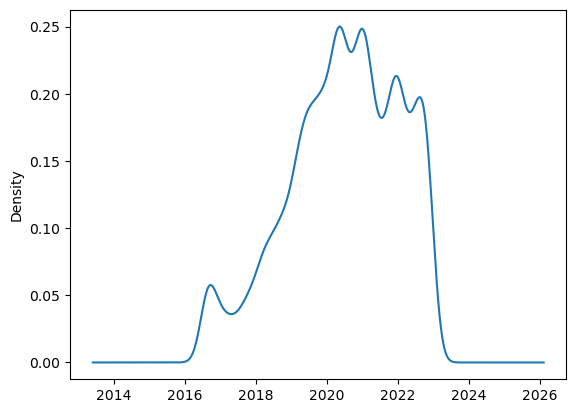

In [32]:
def plot_date_density(df, date_column):
    # https://stackoverflow.com/questions/31348737/how-to-plot-kernel-density-plot-of-dates-in-pandas
    start_date = '2016-1-1'
    df['rel'] = df[date_column] - pd.to_datetime(start_date)
    df.rel = df.rel.astype('timedelta64[D]')
    df['year_as_float'] = pd.to_datetime(start_date).year + df.rel / 365.

    df['year_as_float'].plot.density()

plot_date_density(ai_posts_featurized, 'last_activity_date')

In [33]:
from collections import Counter

all_tags = []
for tag_str in ai_posts_featurized['tags'].values:
    if (tag_str == tag_str) and tag_str != None: # not NaN or None
        tags = tag_str.split(';')
        all_tags.extend(tags) # add the elements of 'tags' to 'all_tags'
    
# len(all_tags) # 36223

tag_counts = Counter(all_tags)

# Set a threshold instead of just taking the top N so ties are not broken by insertion order, 
# which is non-deterministic since we joined the posts to the embeddings.
top_tag_counts = [(tag, tally) for (tag, tally) in tag_counts.most_common() if tally > 60]
top_tag_counts

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 35, Finished, Available)

[('neural-networks', 2327),
 ('reinforcement-learning', 2198),
 ('machine-learning', 2095),
 ('deep-learning', 1803),
 ('convolutional-neural-networks', 1066),
 ('natural-language-processing', 628),
 ('reference-request', 453),
 ('computer-vision', 449),
 ('deep-rl', 444),
 ('comparison', 430),
 ('classification', 426),
 ('training', 410),
 ('terminology', 376),
 ('q-learning', 353),
 ('recurrent-neural-networks', 334),
 ('python', 323),
 ('tensorflow', 319),
 ('dqn', 308),
 ('papers', 306),
 ('image-recognition', 278),
 ('long-short-term-memory', 270),
 ('ai-design', 265),
 ('datasets', 251),
 ('objective-functions', 250),
 ('keras', 240),
 ('game-ai', 237),
 ('backpropagation', 235),
 ('math', 227),
 ('generative-adversarial-networks', 220),
 ('object-detection', 210),
 ('optimization', 207),
 ('definitions', 197),
 ('gradient-descent', 188),
 ('transformer', 186),
 ('applications', 184),
 ('markov-decision-process', 183),
 ('philosophy', 179),
 ('pytorch', 179),
 ('policy-gradients'

In [34]:
flag_cols = {}

top_tags = [tt[0] for tt in top_tag_counts]

tag_strings = ['' if ts is None else ts for ts in ai_posts_featurized['tags'].values]

# len(tag_strings) # 22515
# Counter(tag_strings).most_common(1) # [('', 11808)]; about half of the posts have no tags

for tag in top_tags:
    flag_cols[tag] = [1 if tag in tag_str.split(';') else 0 for tag_str in tag_strings ]
    # This way 'search' does not match 'research'

flags_pdf = pd.DataFrame(flag_cols).reset_index().rename(columns={'index': 'post_id'})
flags_pdf

# flags_pdf.sum(axis=0)  # get sum of each column

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 36, Finished, Available)

,post_id,neural-networks,reinforcement-learning,machine-learning,deep-learning,convolutional-neural-networks,natural-language-processing,reference-request,computer-vision,deep-rl,...,yolo,pattern-recognition,alphazero,chat-bots,environment,off-policy-methods,neuroevolution,model-request,image-generation,features
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22497,22497,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22498,22498,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22499,22499,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
22500,22500,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
my_Cs = 10**np.linspace(-1, 3, 17) 

print(my_Cs)

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 37, Finished, Available)

[1.00000000e-01 1.77827941e-01 3.16227766e-01 5.62341325e-01
 1.00000000e+00 1.77827941e+00 3.16227766e+00 5.62341325e+00
 1.00000000e+01 1.77827941e+01 3.16227766e+01 5.62341325e+01
 1.00000000e+02 1.77827941e+02 3.16227766e+02 5.62341325e+02
 1.00000000e+03]


In [57]:
tags_rdd = sc.parallelize(top_tags, len(top_tags))
print("number of partitions:", tags_rdd.getNumPartitions())

X_all = [v for v in ai_posts_featurized['text_embedding']]

def predict_tag(tag):
    y_all = [f for f in flags_pdf[tag]]

    clf = LogisticRegressionCV(Cs=my_Cs, cv=3, max_iter=5000, scoring='roc_auc', random_state=42).fit(X_all, y_all)

    scores = clf.predict_proba(X_all)[:,1]
    return (tag, scores, clf)

tag_results = tags_rdd.map(predict_tag).collect()

scores_pdf = pd.DataFrame({r[0]:r[1] for r in tag_results})
scores_pdf

# 9 min 42 sec cold

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 59, Finished, Available)

number of partitions: 107


,neural-networks,reinforcement-learning,machine-learning,deep-learning,convolutional-neural-networks,natural-language-processing,reference-request,computer-vision,deep-rl,comparison,...,yolo,pattern-recognition,alphazero,chat-bots,environment,off-policy-methods,neuroevolution,model-request,image-generation,features
0,0.001853,0.063042,0.005981,0.010160,0.000052,0.000129,0.000874,0.001109,0.025545,0.000453,...,0.000129,0.000031,0.002556,0.000451,0.025568,0.002759,0.000949,0.000084,0.000064,0.000533
1,0.078552,0.000019,0.028610,0.009726,0.000129,0.000175,0.002680,0.000273,0.000432,0.003324,...,0.000047,0.000889,0.000111,0.000226,0.000117,0.000002,0.001221,0.001907,0.000014,0.001392
2,0.003882,0.081358,0.024026,0.003134,0.000391,0.002218,0.003016,0.000319,0.002305,0.012531,...,0.000073,0.000059,0.000386,0.000068,0.002587,0.004806,0.000359,0.000067,0.000394,0.000903
3,0.001730,0.050654,0.003625,0.008316,0.000149,0.000944,0.010139,0.001168,0.018252,0.005935,...,0.000095,0.000164,0.000575,0.000576,0.002534,0.000674,0.000891,0.000247,0.000011,0.000395
4,0.002528,0.000004,0.004998,0.000683,0.000379,0.000937,0.007230,0.002310,0.000029,0.085315,...,0.000028,0.000461,0.000431,0.000522,0.000113,0.000046,0.000745,0.000128,0.000051,0.000467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22497,0.019534,0.000690,0.008077,0.006483,0.001297,0.000749,0.005901,0.001068,0.000375,0.001011,...,0.000148,0.000907,0.000164,0.000711,0.000433,0.000107,0.004257,0.000195,0.000386,0.000257
22498,0.048818,0.001659,0.088311,0.297761,0.707115,0.000468,0.000612,0.045214,0.001443,0.000153,...,0.001712,0.000283,0.000205,0.000444,0.000470,0.000112,0.000619,0.000661,0.000098,0.004614
22499,0.813453,0.036770,0.121269,0.102839,0.005290,0.000678,0.004887,0.003123,0.014630,0.011636,...,0.000730,0.006331,0.000304,0.000195,0.000592,0.000544,0.062989,0.003341,0.000055,0.000637
22500,0.010579,0.000715,0.021480,0.083186,0.000908,0.000243,0.000548,0.000318,0.005948,0.000280,...,0.000131,0.000147,0.000447,0.000115,0.000867,0.000067,0.000727,0.000065,0.000086,0.000831


In [37]:
# Pull out the final regularization penalty from each trained model and count how often each value was 
# selected. We want to be sure we tried more extreme values than the ones that were selected.

c_dict = Counter([r[2].C_[0] for r in tag_results])

for key in sorted(c_dict):
    print(f"{key}: {c_dict[key]}")

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 39, Finished, Available)

1.7782794100389228: 1
3.1622776601683795: 6
5.623413251903491: 20
10.0: 40
17.78279410038923: 30
31.622776601683793: 7
56.23413251903491: 2
316.22776601683796: 1


In [38]:
# Show the cross-validation AUCs

cv_auc = {}
for tr in tag_results:
    tag = tr[0]
    clf = tr[2]
    # clf.scores_[1] contains 3-fold cross-validation scores for each C (regularization) value
    cv_auc[tag] = max( np.mean(clf.scores_[1], axis=0) )

# or, in write-only format:
# cv_auc = {tr[0]: max( np.mean(tr[2].scores_[1], axis=0) )  for tr in tag_results}

cv_auc_df = pd.DataFrame({'tag':cv_auc.keys(), 'cross_validation_auc': cv_auc.values()}).sort_values('cross_validation_auc', ascending=False)
cv_auc_df

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 40, Finished, Available)

,tag,cross_validation_auc
99,alphazero,0.997406
100,chat-bots,0.996674
91,neat,0.996557
97,yolo,0.996450
102,off-policy-methods,0.996362
...,...,...
41,deep-neural-networks,0.883801
83,architecture,0.881194
3,deep-learning,0.874968
2,machine-learning,0.867376


In [39]:
# Print the mean cross-validation AUC

mean_cv_auc = cv_auc_df.loc[:, 'cross_validation_auc'].mean()
print("Mean cross-validation AUC:", mean_cv_auc)

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 41, Finished, Available)

Mean cross-validation AUC: 0.9650418444613081


# Show examples most likely to need curation

In [40]:
def show_top_and_bottom(tag, num_examples=10):
    """ Display the highest scoring unflagged examples (most probable false negatives)
    and the lowest scoring flagged examples (most probable false positives)"""
    
    from pandas import option_context

    keep_cols = ['text'] # , 'tags', 'last_activity_date']
    df = ai_posts_featurized[keep_cols].copy()
    df['flag'] = flags_pdf[tag]
    df['score'] = scores_pdf[tag]

    df = df.sort_values('score', ascending=False)

    with option_context('display.max_colwidth', 0):
        print("Highest scoring unflagged examples:")
        display(df[df['flag'] == 0].head(num_examples))
        print("Lowest scoring flagged examples:")
        display(df[df['flag'] == 1].tail(num_examples))


show_top_and_bottom('alphazero')

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 42, Finished, Available)

Highest scoring unflagged examples:


/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


SynapseWidget(Synapse.DataFrame, 6eb12cfc-e4c7-4d2d-81b8-a5063704a165)

Lowest scoring flagged examples:


SynapseWidget(Synapse.DataFrame, 2adc932e-2617-4e26-ba41-3c6f1047121e)

In [41]:
show_top_and_bottom('machine-learning')

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 43, Finished, Available)

Highest scoring unflagged examples:


/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


SynapseWidget(Synapse.DataFrame, bbe67799-0447-48a9-bc1b-d54c7e2a1275)

Lowest scoring flagged examples:


SynapseWidget(Synapse.DataFrame, 4120db3d-c601-487b-9f8c-3cdeef6e7213)

# Correlation Matrixes

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 44, Finished, Available)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


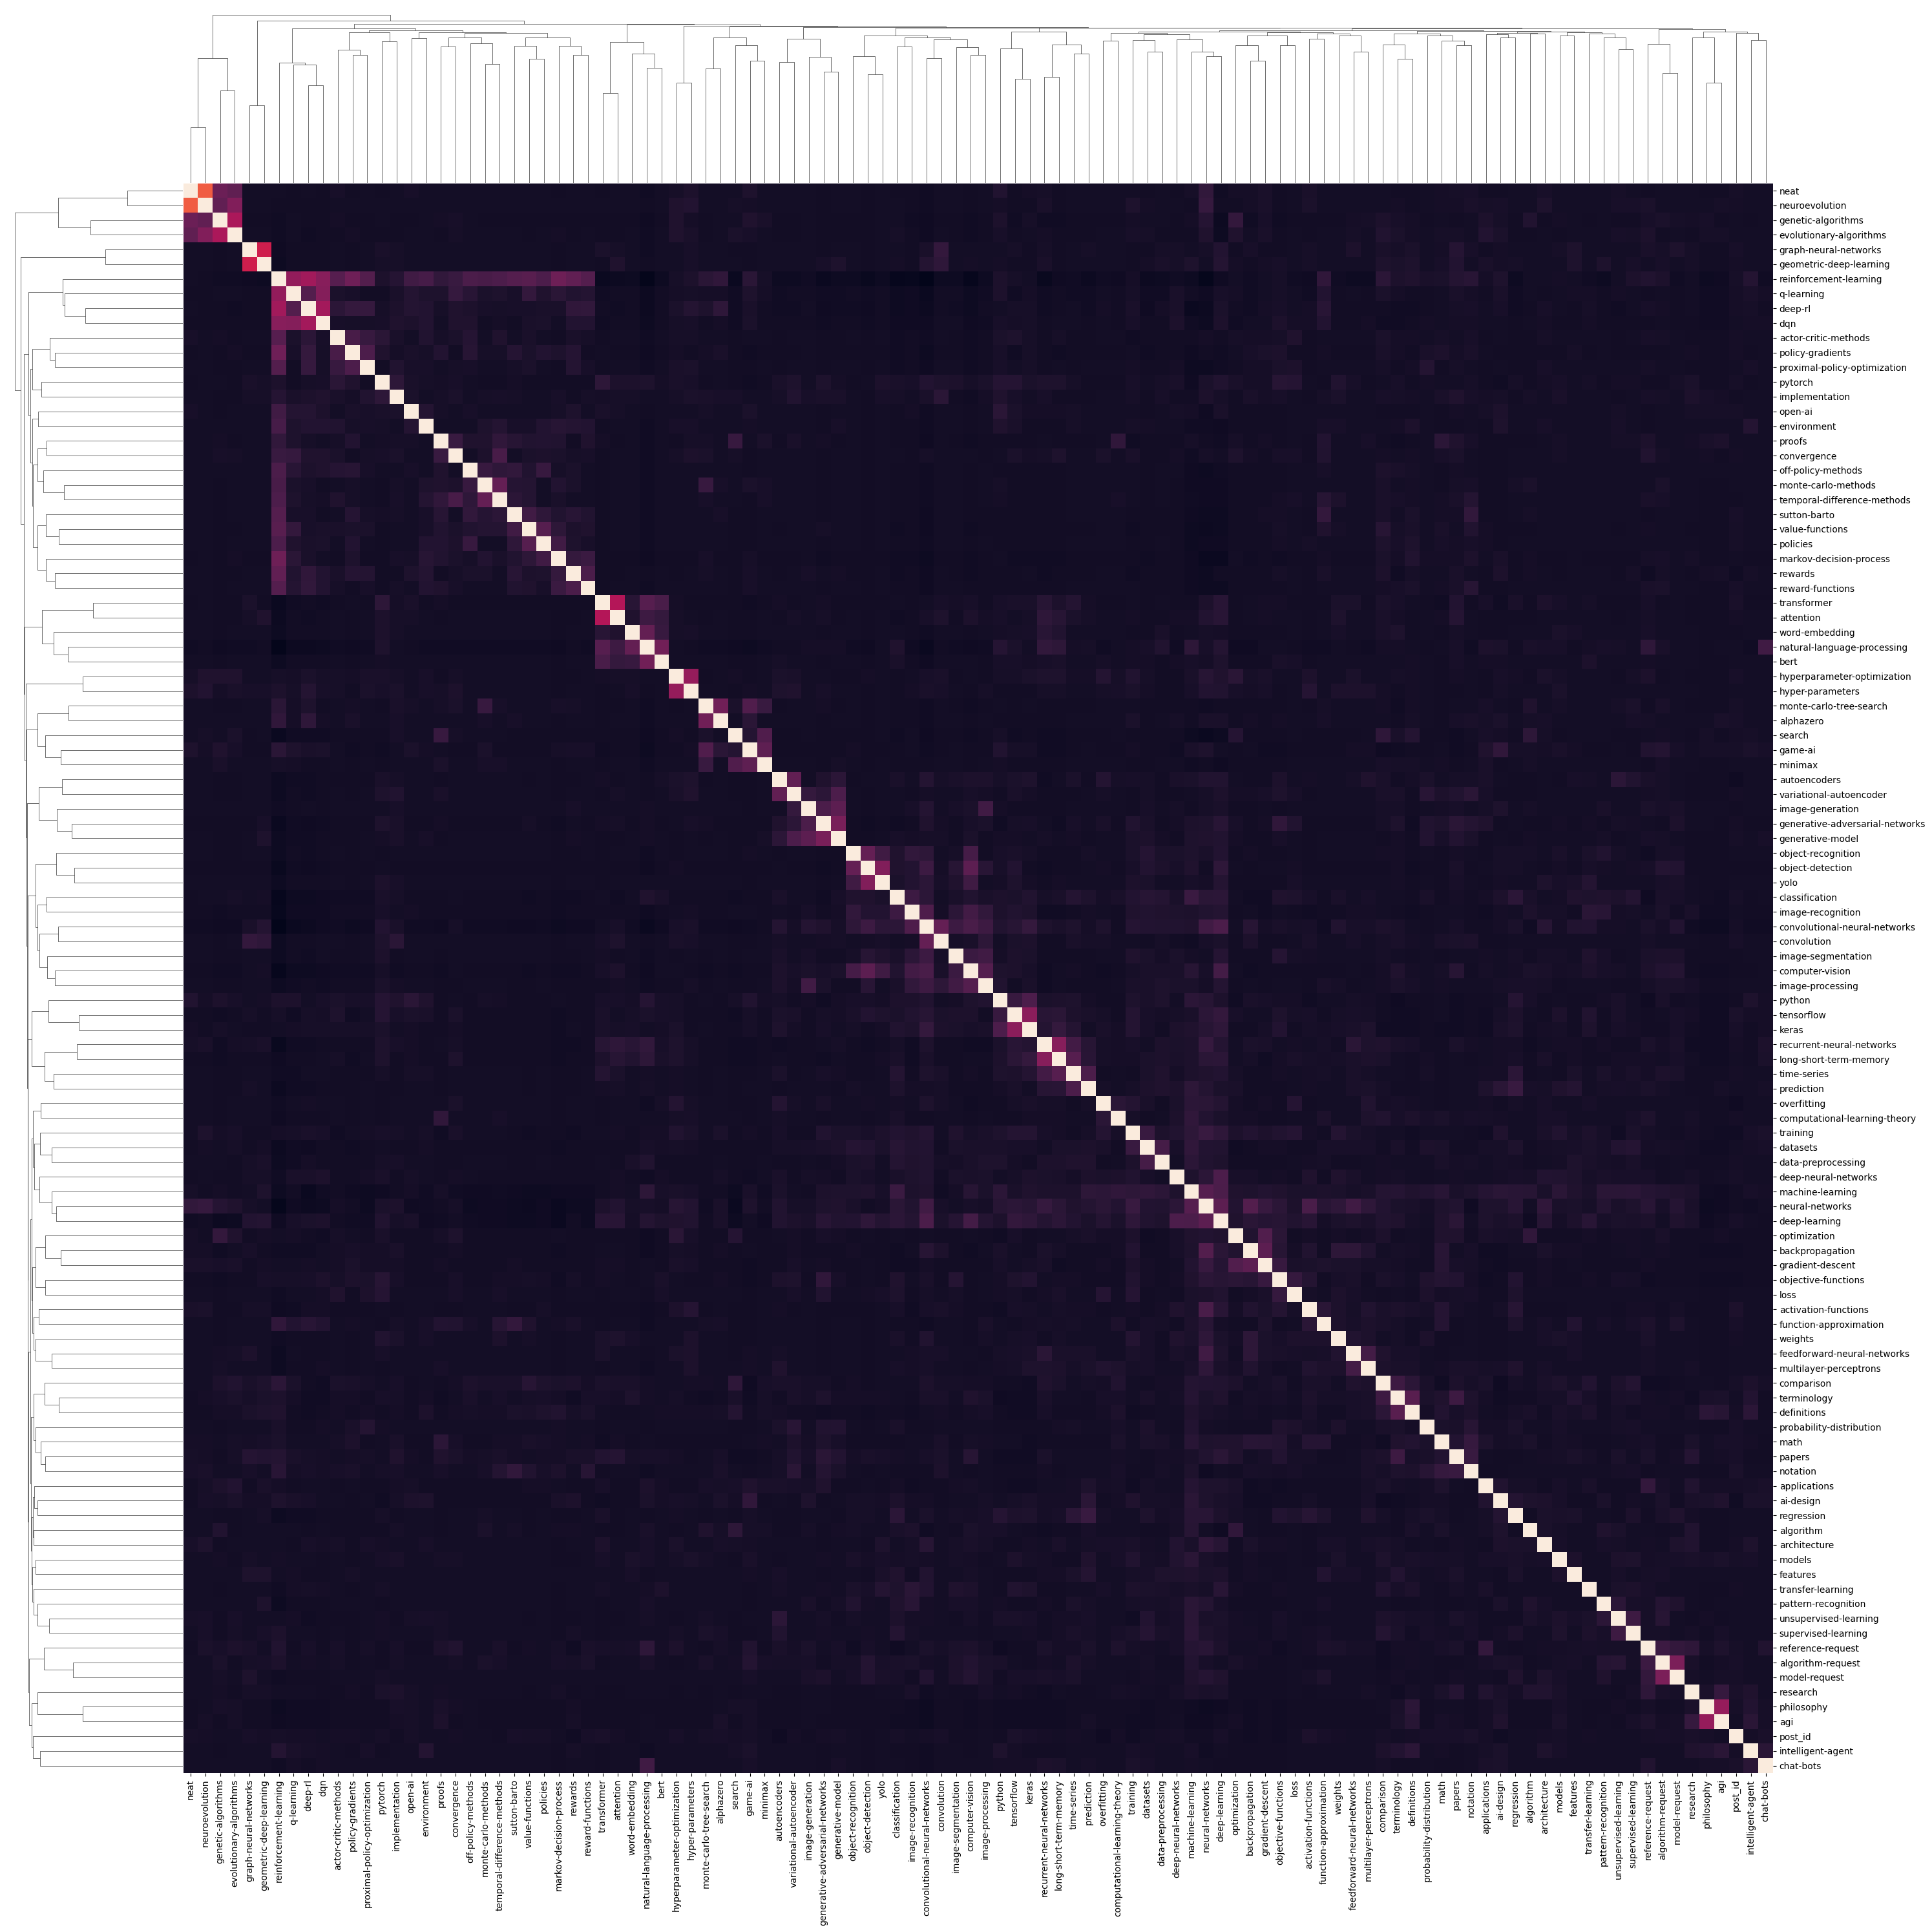

In [42]:
sns.clustermap(flags_pdf.corr(), figsize=(30,30), dendrogram_ratio=0.1, cbar_pos=None)

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 45, Finished, Available)

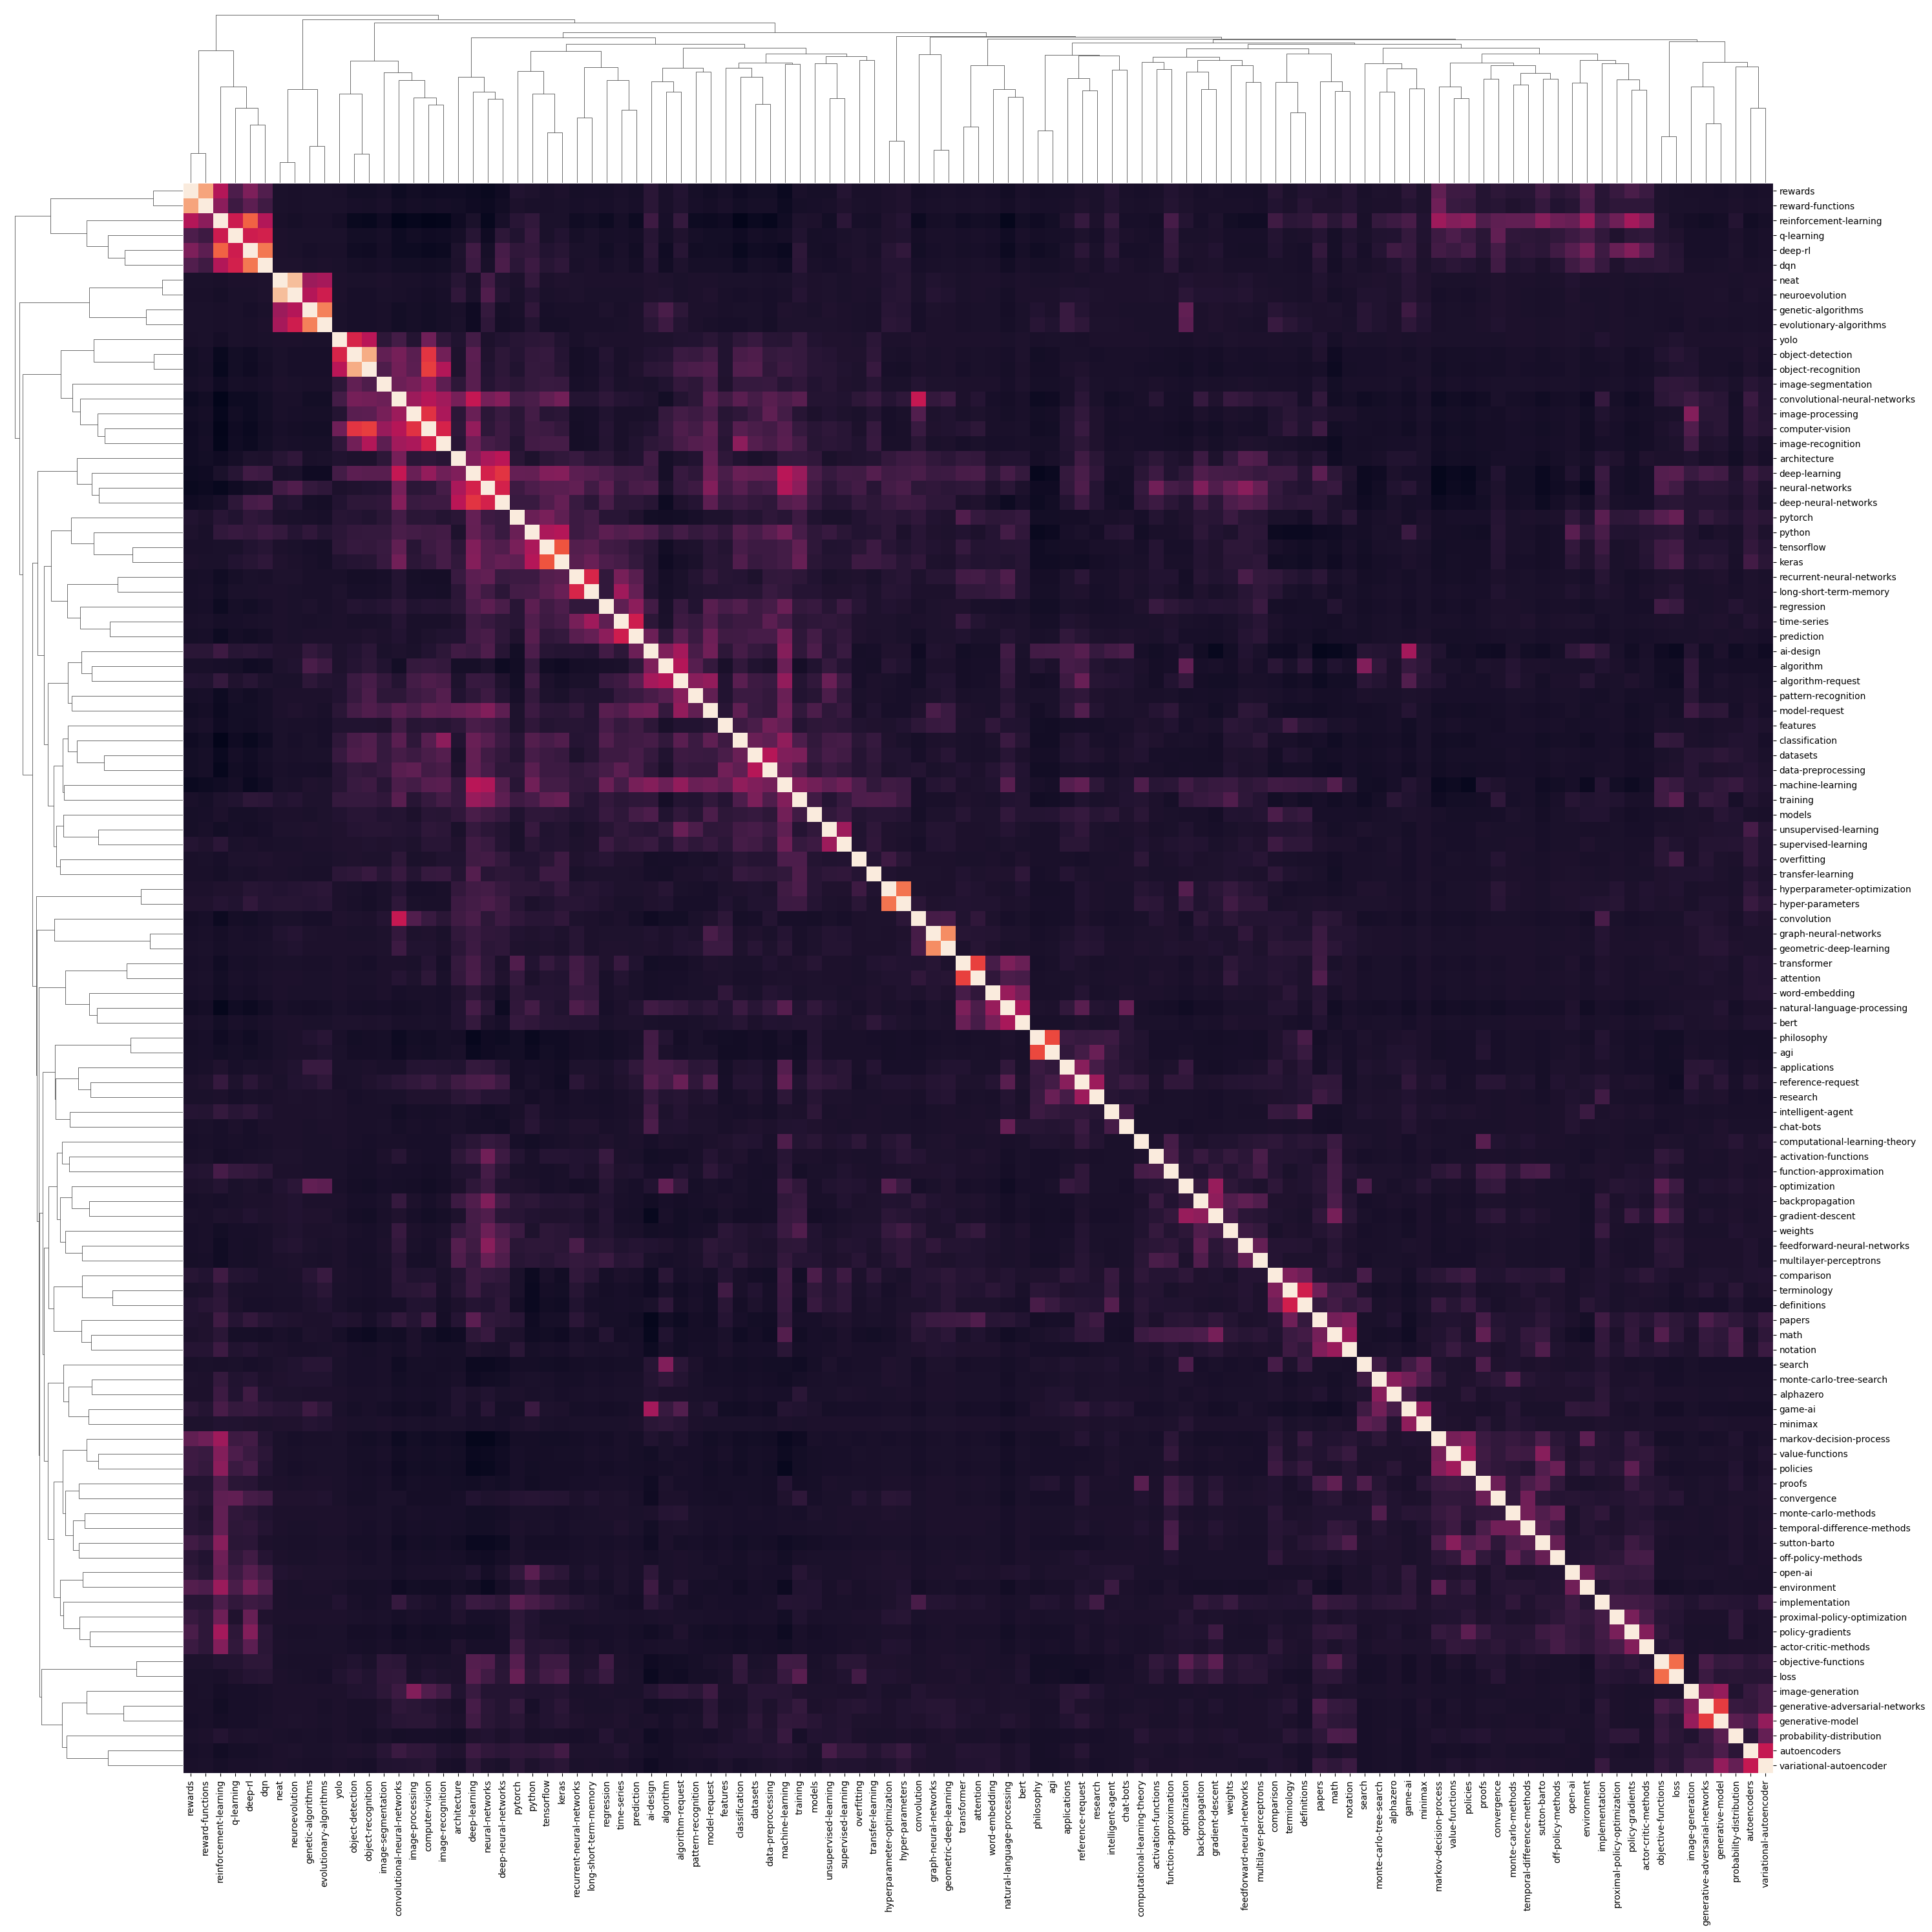

In [43]:
sns.clustermap(scores_pdf.corr(), figsize=(30,30), dendrogram_ratio=0.1, cbar_pos=None)

In [44]:
M = flags_pdf.corr()
M['machine-learning'][M['machine-learning'] > 0.1]

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 46, Finished, Available)

neural-networks     0.179987
machine-learning    1.000000
deep-learning       0.150487
classification      0.105867
Name: machine-learning, dtype: float64

# What threshold gives 95% recall?
We'll assume that most incorrect tags are just missing.

In [45]:
def threshold_at_recall(tag, recall_level=0.95):
    scores = scores_pdf[tag]
    flags = flags_pdf[tag]

    # pd.DataFrame({'score':scores, 'flag': flags}).sort_values('score')

    fpr, tpr, thresholds = metrics.roc_curve(flags, scores)
    auc = metrics.roc_auc_score(flags, scores)

    roc_df = pd.DataFrame({'fpr':fpr, 'tpr': tpr, 'threshold': thresholds})
    threshold = max(roc_df[roc_df['tpr'] > recall_level]['threshold'])

    return {'tag': tag, 'threshold': threshold, 'auc': auc}


tag_threshold_auc = pd.DataFrame([threshold_at_recall(tag) for tag in top_tags]).sort_values('auc').set_index('tag')
tag_threshold_auc

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 47, Finished, Available)

,threshold,auc
tag,,
machine-learning,0.054915,0.909533
deep-learning,0.057117,0.919805
ai-design,0.007611,0.934989
neural-networks,0.062706,0.946982
deep-neural-networks,0.008807,0.952629
...,...,...
image-generation,0.156684,0.999559
yolo,0.137142,0.999584
monte-carlo-methods,0.239454,0.999867


In [46]:
tag_threshold_auc.sort_values('threshold')

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 48, Finished, Available)

,threshold,auc
tag,,
unsupervised-learning,0.005196,0.969816
features,0.006906,0.984509
ai-design,0.007611,0.934989
models,0.007760,0.980723
convergence,0.007828,0.990061
...,...,...
image-generation,0.156684,0.999559
reinforcement-learning,0.199225,0.991647
monte-carlo-methods,0.239454,0.999867


In [47]:
predicted_flag_dict = {}
for tag in top_tags:
    threshold = tag_threshold_auc.loc[tag]['threshold']
    predicted_flag_dict[tag] = [int(b) for b in (scores_pdf[tag] >= threshold)]

predicted_flag_pdf = pd.DataFrame(predicted_flag_dict).reset_index().rename(columns={'index': 'post_id'})
predicted_flag_pdf

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 49, Finished, Available)

,post_id,neural-networks,reinforcement-learning,machine-learning,deep-learning,convolutional-neural-networks,natural-language-processing,reference-request,computer-vision,deep-rl,...,yolo,pattern-recognition,alphazero,chat-bots,environment,off-policy-methods,neuroevolution,model-request,image-generation,features
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22497,22497,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22498,22498,0,0,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
22499,22499,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
22500,22500,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
tag_counts = pd.DataFrame({'original': flags_pdf[top_tags].sum(axis=0), 
                           'predicted': predicted_flag_pdf[top_tags].sum(axis=0)})
tag_counts['ratio'] = tag_counts['predicted']/tag_counts['original']
tag_counts.sort_values('ratio')

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 50, Finished, Available)

,original,predicted,ratio
minimax,68,68,1.000000
proximal-policy-optimization,96,99,1.031250
monte-carlo-methods,75,85,1.133333
reinforcement-learning,2198,2697,1.227025
image-generation,61,85,1.393443
...,...,...,...
models,98,2292,23.387755
architecture,76,1797,23.644737
deep-neural-networks,169,4959,29.343195
ai-design,265,7835,29.566038


StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 51, Finished, Available)

(-24.403000000000002, 2440.3)

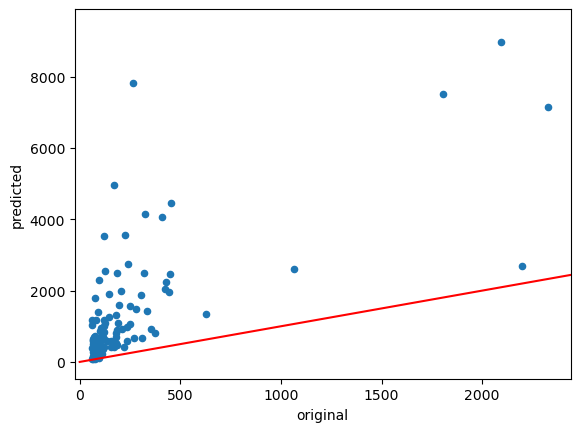

In [49]:
ax = tag_counts.plot.scatter(x='original', y='predicted')

max_x = max(ax.get_xlim()) # includes padding
max_y = max(ax.get_ylim())
max_val = max( max_x, max_y )

ax.plot([0, max_val], [0, max_val], c='red')
ax.set_xlim( -(max_x/100), max_x)

In [50]:
tag_counts[tag_counts['original'] > 2000]

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 52, Finished, Available)

,original,predicted,ratio
neural-networks,2327,7149,3.072196
reinforcement-learning,2198,2697,1.227025
machine-learning,2095,8978,4.285442


# Co-occurrence

In [51]:
def get_item_pair_stats(item_pair_df):
    # item_pair_df must have columns named 'basket', and 'item'.
    
    import sqlite3 # we're using this for portability; you can run this code on your favorite SQL database.

    db = sqlite3.connect(":memory:")
    
    item_pair_df.to_sql("basket_item", db, if_exists="replace")


    ITEM_PAIR_STATS_QUERY = """with 
      bi as (
        select basket, item
          from basket_item
          group by basket, item  -- be sure we only count one of each kind of item per basket
      ),
      item_counts as (
        select item, count(*) item_count -- same as the number of baskets containing this item (see above)
          from bi
          group by item
      ),
      bi_count as (
        select bi.*, ic.item_count  -- basket, item, item_count
          from bi
            join item_counts ic on bi.item=ic.item
      ),
      ips as (
          select bi1.item item1, bi2.item item2,
                  bi1.item_count item1_count, bi2.item_count item2_count,
                  count(*) as both_count              
              from bi_count bi1
                join bi_count bi2  -- joining the table to itself
                  on bi1.basket = bi2.basket  -- two items in the same basket
                  and bi1.item != bi2.item    -- don't count the item being in the basket with itself
              group by bi1.item, bi1.item_count, 
                       bi2.item, bi2.item_count
      ),
      cc as (
        SELECT item1, item2, item1_count, item2_count, both_count,
              CAST(item1_count AS FLOAT)/(select count(distinct basket) from basket_item) as item1_prevalence, -- fraction of all baskets with item1
              CAST(item2_count AS FLOAT)/(select count(distinct basket) from basket_item) as item2_prevalence, -- fraction of all baskets with item2
              CAST(both_count AS FLOAT)/CAST(item1_count AS FLOAT) AS confidence  -- fraction of baskets with item1 that also have item2
          FROM ips
      )
    select *, confidence/item2_prevalence lift from cc
    """

    return pd.read_sql_query(ITEM_PAIR_STATS_QUERY, db)


def get_nodes_and_edges_from_item_pair_stats(cooccurrence_pdf):
    """
    Convert a Pandas dataframe of item-pair statistics to separate dataframes for nodes and edges.
    """
    from collections import Counter
    
    item_stats = {r['item1']:{'count':r['item1_count'], 'prevalence':r['item1_prevalence']} 
                    for idx, r in cooccurrence_pdf.iterrows()}
 
    item_stats.update({r['item2']:{'count':r['item2_count'], 'prevalence':r['item2_prevalence']} 
                    for idx, r in cooccurrence_pdf.iterrows()})
 
    nodes_df = pd.DataFrame([{'label':k,'count':v['count'], 'prevalence':v['prevalence']}  
                    for k,v in item_stats.items()])
    nodes_df['id'] = nodes_df.index
   
    edges_df = cooccurrence_pdf.copy()
    node_id = {r['label']:r['id'] for idx, r in nodes_df.iterrows()}
    edges_df['from'] = [node_id[nn] for nn in edges_df['item1']]
    edges_df['to'] = [node_id[nn] for nn in edges_df['item2']]
    
    print("Your graph will have {0} nodes and {1} edges.".format( len(nodes_df), len(edges_df) ))
 
    return nodes_df, edges_df[[ 'from', 'to', 'both_count', 'confidence', 'lift']]


def get_vis_js_html(nodes_df, edges_df):
    """
    Generate HTML encoding vis_js graph from Pandas dataframes of nodes and edges.
    """
    nodes_str = nodes_df.to_json(orient='records')
    edges_str = edges_df.to_json(orient='records')
    
    max_weight = max(edges_df['weight'])

    html_string = ( 
    f'    <script type="text/javascript">NODE_LIST={nodes_str};FULL_EDGE_LIST={edges_str};</script>\n'
    '\n'
        '\n'
    '        <script type="text/javascript" src="https://unpkg.com/vis-network/standalone/umd/vis-network.min.js"></script>\n'
    '        <script type="text/javascript">\n'
    '            function hello(){console.info("hello")}\n'
    '\n'
    '            const sign_color = {pos:"blue", neg:"red", zero:"black"}\n'
    '            const options = {physics:{maxVelocity: 1, minVelocity: 0.01}}\n'
    '            var edgeFilterSlider\n'
    '            var mynetwork\n'
    '            var motion_flag = false\n'
    '            function toggle_motion(){\n'
    '                motion_flag = !motion_flag\n'
    '                mynetwork.setOptions( { physics: motion_flag } )\n'
    '            }\n'
    '\n'
    '            function edgesFilter(edge){\n'
    '                return edge.value >= edgeFilterSlider.value\n'
    '            }\n'
    '\n'
    '            function init_network(){\n'
    '                document.getElementById("min_edge_weight_display").value = 0.5\n'
    '                document.getElementById("min_edge_weight").onchange = function(){\n'
    '                    document.getElementById("min_edge_weight_display").value = this.value\n'
    '                }\n'
    '\n'
    '                edgeFilterSlider = document.getElementById("min_edge_weight")\n'
    '                edgeFilterSlider.addEventListener("change", (e) => {edgesView.refresh()})\n'
    '                var container = document.getElementById("mynetwork")\n'
    '                var EDGE_LIST = []\n'
    '                for (var i = 0; i < FULL_EDGE_LIST.length; i++) {\n'
    '                    var edge = FULL_EDGE_LIST[i]\n'
    '                    edge["value"] = Math.abs(edge["weight"])\n'
    '                    edge["title"] = "weight " + edge["weight"]\n'
    '                    edge["sign"] = (edge["weight"] < 0) ? "neg" : "pos";\n'
    '                    edge["color"] = {color: sign_color[edge["sign"]] };\n'
    '                    edge["arrows"] = "to"\n'
    '                    EDGE_LIST.push(edge)\n'
    '                }\n'
    '\n'
    '                var nodes = new vis.DataSet(NODE_LIST)\n'
    '                var edges = new vis.DataSet(EDGE_LIST)\n'
    '                var nodesView = new vis.DataView(nodes)\n'
    '                var edgesView = new vis.DataView(edges, { filter: edgesFilter })\n'
    '                var data = { nodes: nodesView, edges: edgesView }\n'
    '                mynetwork = new vis.Network(container, data, options)\n'
    '\n'
    '            }\n'
    '            init_network()\n'
    '        </script>\n'
    '        <style type="text/css">#mynetwork {width: 100%; height: 500px; border: 3px}</style>\n'
    '        <button onclick=toggle_motion()>Toggle motion</button>\n'
    '        <div class="slidercontainer">\n'
    '            <label>minimum edge weight:\n'
    f'                <input type="range" min="0" max="{max_weight}" value="{max_weight/2}" step="{max_weight/100}" class="slider" id="min_edge_weight">\n'
    '                <input type="text" id="min_edge_weight_display" size="2">\n'
    '            </label>\n'
    '        </div>\n'
    '        <div id="mynetwork"></div>\n'

    )
    return html_string
        
    
def export_to_vis_js(nodes_df, edges_df, title, html_file_name):
    """
    Generate vis_js graph from Pandas dataframes of nodes and edges, and write to HTML file.
    """
    
    vis_js_html = get_vis_js_html(nodes_df, edges_df)
    page_html =  ('<!DOCTYPE html>\n'
        '<html lang="en">\n'
        '    <head>\n'
        f'       <title>{title}</title>\n'
        '    </head>\n'
        '    <body onload=init_network()>\n'
        f'{vis_js_html}'
        '\n'
        '    </body>\n'
        '</html>\n')
    
    with open(html_file_name, "wt") as html_file: 
        html_file.write(page_html)

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 53, Finished, Available)

In [52]:
flags_long = pd.melt(flags_pdf, id_vars='post_id')
flags_long = flags_long[flags_long['value'] == 1]
flags_long = flags_long[['post_id', 'variable']].sort_values('post_id')

flags_long

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 54, Finished, Available)

,post_id,variable
1552694,56,overfitting
67563,57,deep-learning
1260169,57,hyperparameter-optimization
90085,77,convolutional-neural-networks
360109,77,tensorflow
...,...,...
337527,22499,recurrent-neural-networks
2070181,22499,neat
2340205,22499,neuroevolution
22499,22499,neural-networks


In [53]:
flags_ips = get_item_pair_stats(flags_long.rename(columns={'post_id':'basket', 'variable':'item'}))

flags_ips.sort_values('confidence', ascending=False)[0:15]

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 55, Finished, Available)

,item1,item2,item1_count,item2_count,both_count,item1_prevalence,item2_prevalence,confidence,lift
4930,sutton-barto,reinforcement-learning,80,2198,78,0.007849,0.215638,0.975000,4.521463
4776,reward-functions,reinforcement-learning,79,2198,77,0.007750,0.215638,0.974684,4.519995
3620,off-policy-methods,reinforcement-learning,64,2198,60,0.006279,0.215638,0.937500,4.347560
4817,rewards,reinforcement-learning,120,2198,112,0.011773,0.215638,0.933333,4.328238
5438,value-functions,reinforcement-learning,98,2198,91,0.009614,0.215638,0.928571,4.306155
4964,temporal-difference-methods,reinforcement-learning,70,2198,64,0.006867,0.215638,0.914286,4.239906
3988,policy-gradients,reinforcement-learning,178,2198,161,0.017463,0.215638,0.904494,4.194500
3942,policies,reinforcement-learning,77,2198,68,0.007554,0.215638,0.883117,4.095364
87,actor-critic-methods,reinforcement-learning,106,2198,93,0.010399,0.215638,0.877358,4.068660
4377,q-learning,reinforcement-learning,353,2198,309,0.034632,0.215638,0.875354,4.059365


In [54]:
flags_nodes, flags_edges = get_nodes_and_edges_from_item_pair_stats( flags_ips[ flags_ips['both_count'] > 50 ] )

flags_nodes['title'] = flags_nodes['label']  # mouseover text
flags_edges['weight'] = flags_edges['confidence']

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 56, Finished, Available)

Your graph will have 56 nodes and 200 edges.


## Co-occurrence graph from original tags

In [55]:
vis_js_html = get_vis_js_html(flags_nodes, flags_edges)
displayHTML(vis_js_html)

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 57, Finished, Available)

## Co-occurrence graph from predicted tags

In [56]:
predicted_flag_long = pd.melt(predicted_flag_pdf, id_vars='post_id')
predicted_flag_long = predicted_flag_long[predicted_flag_long['value'] == 1]
predicted_flag_long = predicted_flag_long[['post_id', 'variable']].sort_values('post_id')

predicted_ips = get_item_pair_stats(predicted_flag_long.rename(columns={'post_id':'basket', 'variable':'item'}))
predicted_ips.sort_values('confidence', ascending=False)[0:15]

predicted_nodes, predicted_edges = get_nodes_and_edges_from_item_pair_stats( predicted_ips[ (predicted_ips['both_count'] > 50) & (predicted_ips['lift'] > 4) ] )

predicted_nodes['title'] = predicted_nodes['label']  # mouseover text
predicted_edges['weight'] = predicted_edges['confidence']

vis_js_html = get_vis_js_html(predicted_nodes, predicted_edges[predicted_edges['weight'] > 0.25])
displayHTML(vis_js_html)

StatementMeta(, 27215701-628f-4fed-a047-e60edef6ad0e, 58, Finished, Available)

Your graph will have 96 nodes and 506 edges.
